In [2]:
BAN_ANNOTATORS = [
    "annotator_2@mail.com",
    "annotator_5@mail.com",
    "annotator_6@mail.com",
    "annotator_8@mail.com",
    "annotator_10@mail.com"
]

In [3]:
TRANSLATION_TOPICS = {
    "Rapport qualité-prix": "Value for Money",
    "Ambiance": "Ambience",
    "Chambre": "Room",
    "Emplacement": "Location",
    "Personnel": "Staff"
}

In [4]:
ALIAS_MODEL = {
    "Mistral-Small-3.2-24B-Instruct-2506": "Mistral-3.2-24B",
    "gemma-3-27b-it": "Gemma-3-27B",
    "gemma-3-12b-it": "Gemma-3-12B",
    "Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Mistral-Nemo-Instruct-FP8-2407": "Mistral-Nemo-12B",
    "Ministral-8B-Instruct-2410": "Ministral-8B",
    "Llama-3.3-70B-Instruct": "Llama-3.3-70B"
}

In [5]:
import pandas as pd

# Load TSV
df = pd.read_csv("../data/score/mattcoef_annotator_per_model.tsv", sep="\t")

# 1. Remove 'keywords-' prefix in 'Model'
df = df[~df['Model'].str.contains('1B|3B|keywords-|Llama-3.3-70B-Instruct-FP8')]



# Melt to long format
df_long = df.melt(
    id_vars=["Model", "Annotator"],
    var_name="Topic",
    value_name="MCC"
)

# Optionally filter annotators
df_long = df_long[~df_long["Annotator"].isin(BAN_ANNOTATORS)]
df_long['Model'] = df_long['Model'].map(ALIAS_MODEL)

df_long['Topic'] = df_long['Topic'].map(TRANSLATION_TOPICS)

df= df_long



In [6]:
model_order = sorted(
    ALIAS_MODEL.values(),
    key=lambda x: (       
        int(x.split('-')[-1][0:-1]),
        x.split('-')[0],            # size
    )
)


In [7]:
model_order

['Llama-3.1-8B',
 'Ministral-8B',
 'Gemma-3-12B',
 'Mistral-Nemo-12B',
 'Mistral-3.2-24B',
 'Gemma-3-27B',
 'Llama-3.3-70B']

In [8]:
df

,Model,Annotator,Topic,MCC
0,Mistral-3.2-24B,annotator_13@mail.com,Room,0.831624
1,Mistral-3.2-24B,annotator_3@mail.com,Room,0.953048
2,Mistral-3.2-24B,annotator_4@mail.com,Room,0.944817
5,Mistral-3.2-24B,annotator_1@mail.com,Room,0.856543
6,Mistral-3.2-24B,annotator_7@mail.com,Room,0.853041
...,...,...,...,...
447,Mistral-Nemo-12B,annotator_1@mail.com,Staff,0.919572
448,Mistral-Nemo-12B,annotator_7@mail.com,Staff,0.909928
451,Mistral-Nemo-12B,annotator_9@mail.com,Staff,0.931078
452,Mistral-Nemo-12B,annotator_12@mail.com,Staff,0.939577


/tmp/ipykernel_4840/2913944716.py:13: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.boxplot(


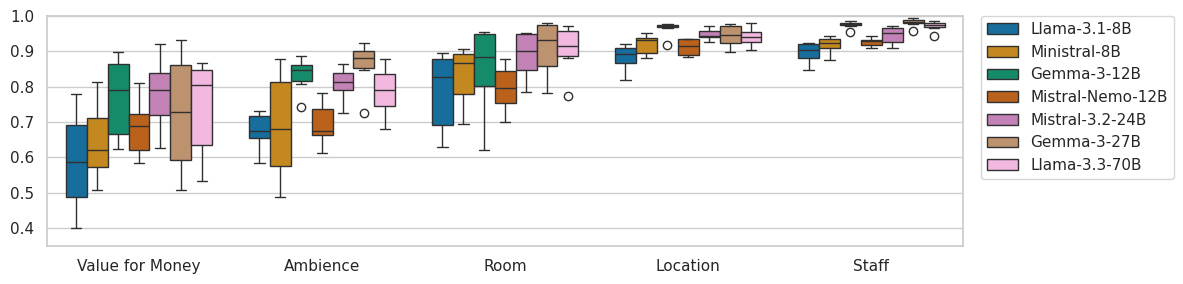

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df
topic_order = TRANSLATION_TOPICS.values()
# Set style
sns.set(style="whitegrid")
palette = sns.color_palette("colorblind")

# Create boxplot
plt.figure(figsize=(12, 3))
ax = sns.boxplot(
    data=df,
    x='Topic',
    y='MCC',
    hue='Model',
    palette=palette,
    hue_order=model_order,      # 👈 model order
    order=topic_order,   # 👈 this is the key line
    showfliers=True  # show individual points outside min-max if any
)

plt.ylim(0.35, 1)  # adjust upper limit if needed

plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout()
plt.savefig('add_topic_inter.png')
plt.show()


In [10]:
import numpy as np

In [11]:
print(df['MCC'].isna().sum())       # Count of NaNs
print(np.isinf(df['MCC']).sum())    # Count of infs

0
0


In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define the formula with all main effects and optionally interactions
formula = 'MCC ~ C(Annotator) + C(Model) + C(Annotator):C(Model)'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

NameError: name 'df' is not defined

In [13]:
# Tukey post-hoc test for Topic
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['MCC'],    # dependent variable
                          groups=df['Topic'], # factor to compare
                          alpha=0.05) 

In [14]:
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1       group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
Ambience        Location   0.1659    0.0    0.12  0.2118   True
Ambience            Room   0.0891    0.0  0.0432   0.135   True
Ambience           Staff     0.18    0.0  0.1341  0.2259   True
Ambience Value for Money  -0.0612 0.0028 -0.1071 -0.0153   True
Location            Room  -0.0768 0.0001 -0.1227 -0.0309   True
Location           Staff   0.0141 0.9164 -0.0318    0.06  False
Location Value for Money  -0.2271    0.0  -0.273 -0.1812   True
    Room           Staff   0.0909    0.0   0.045  0.1369   True
    Room Value for Money  -0.1503    0.0 -0.1962 -0.1043   True
   Staff Value for Money  -0.2412    0.0 -0.2871 -0.1953   True
---------------------------------------------------------------


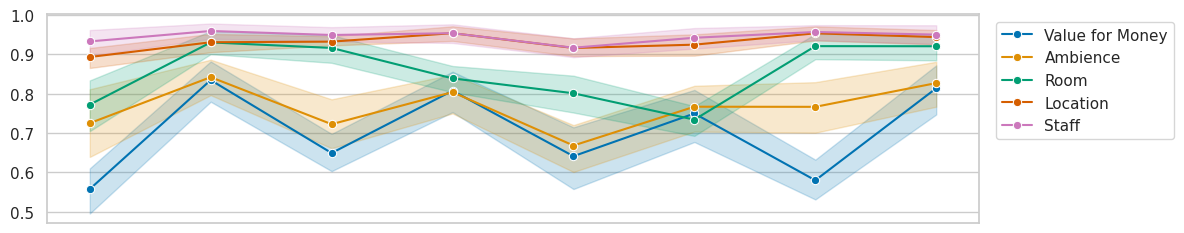

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
df['Topic'] = pd.Categorical(df['Topic'], categories=topic_order, ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)


# Line plot of MCC by Topic, colored by Annotator (legend removed)
plt.figure(figsize=(12,2.5))
sns.lineplot(data=df, x='Annotator', y='MCC', hue='Topic', marker='o', hue_order=TRANSLATION_TOPICS.values(), palette="colorblind")
#plt.title('MCC by Topic and Annotator')
plt.ylabel('')
plt.xticks([])
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('sensibility_topic_annotator.png')
plt.show()

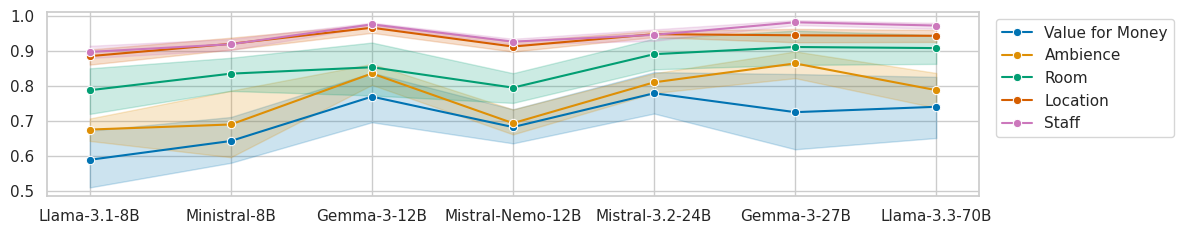

In [19]:
# Line plot of MCC by Topic, colored by Model
plt.figure(figsize=(12,2.5))
sns.lineplot(data=df, x='Model', y='MCC', hue='Topic', marker='o', hue_order=TRANSLATION_TOPICS.values(), palette="colorblind")
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig('sensibility_topic_model.png')
plt.show()

In [17]:
df.to_clipboard()

In [18]:
df.to_clipboard()